# Homework Week 08
Nicola Zomer <br>
23 December, 2022

# Assignment
Study the stability of the excitatory-inhibitory two neurons system (Eq. 7.5 in the notes) for the parameters:
- $M_{EE} = 1.25$, $M_{IE} = 1$, $M_{EI} = -1$, $M_{II} = 0$;  
- $h_{E} = 10\, Hz$, $h_I = - h_E$;
- $\tau_E = 10 \, ms$ 

as a function of the free parameter $\tau_I$. Simulate a trajectory in the stable regime and one in the limit cycle regime (different $\tau_I$).

# Stability analysis
First we define some useful parameters and functions and we compute the fixed point.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

%matplotlib inline

# define the parameters value
M = np.array([[1.25, -1], [1, 0]])
h_E = 10
h_I = -h_E
tau_E = 10
tau_I = 60

print('Weights matrix:\n', M, '\n')

# define activation function --> ReLU
def activation(x):    
    return np.maximum(0, x)

# define system in terms of separated differential equations
def f(vE, vI):
    return 1/tau_E*(-vE+activation(h_E + M[0, 0]*vE + M[0, 1]*vI))
def g(vE, vI, tau_I):
    return 1/tau_I*(-vI+activation(h_I + M[1, 0]*vE + M[1, 1]*vI))

# define system using numpy array
def Sys(v_vec, t, tau_I):
    return np.array([f(v_vec[0], v_vec[1]), g(v_vec[0], v_vec[1], tau_I)])

# initialize lists containing values
vE = []
vI = []

# vE_0, vI_0 = initial values, dt = timestep, time = time range
def sys_dynamics(vE_0, vI_0, dt, time):
    # initial values:
    vE.append(vE_0)
    vI.append(vI_0)
    
    # compute and fill lists
    for i in range(time):
        vE.append(vE[i] + (f(vE, vI)) * dt)
        vI.append(vI[i] + (g(vE, vI, tau_I)) * dt)
    return vE, vI

# fixed point
fp = 1/((1-M[0, 0])*(1-M[1, 1])-M[0, 1]*M[1, 0])*np.array([[1-M[1, 1], M[0, 1]], [M[1, 0], 1-M[0, 0]]]).dot(np.array([h_E, h_I]))

print('Fixed point: \n v_E=%.2f \n v_I=%.2f' %(fp[0], fp[1]))

Weights matrix:
 [[ 1.25 -1.  ]
 [ 1.    0.  ]] 

Fixed point: 
 v_E=26.67 
 v_I=16.67


To show that the stationary solution is unique, we plot the *nullclines* and the phase portrait for $\tau_I=60$. Notice that the nullclines do not depend on $\tau_I$ and they intersect at a single point, which is the fixed point computed above.

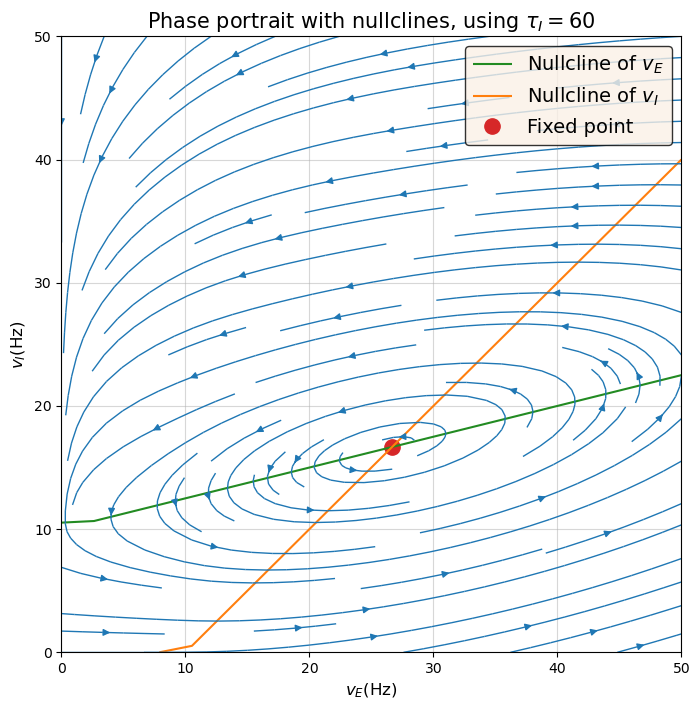

In [2]:
# plot nullclines and quiver
fig, ax = plt.subplots(figsize=(8,8))

# define stationary state equations
def f_steady(vE, vI):
    return -vE+activation(h_E + M[0, 0]*vE + M[0, 1]*vI)
def g_steady(vE, vI):
    return -vI+activation(h_I + M[1, 0]*vE + M[1, 1]*vI)

# plot fixed point
ax.plot(fp[0], fp[1], "ro", markersize = 11, markeredgecolor="C3", markerfacecolor="C3", label='Fixed point')

# quiverplot
# define a grid and compute direction at each point
x = np.linspace(0, 50, 20)
y = np.linspace(0, 50, 20)

X1 , Y1  = np.meshgrid(x, y)                    # create a grid
DX1, DY1 = Sys([X1, Y1], 0, tau_I)              # compute growth rate on the grid
# M_ = (np.hypot(DX1, DY1))                     # norm growth rate 
# M_[ M_ == 0] = 1.                             # avoid zero division errors 
# DX1 /= M_                                     # normalize each arrows
# DY1 /= M_

# nullclines
c1 = ax.contour(X1, Y1, f_steady(X1, Y1), levels=[0], linewidths=1.5, colors='forestgreen')
c2 = ax.contour(X1, Y1, g_steady(X1, Y1), levels=[0], linewidths=1.5, colors='C1')

# ax.quiver(X1, Y1, DX1, DY1, M_, pivot='mid')
ax.streamplot(X1, Y1, DX1, DY1, linewidth=1)

# details
ax.set_xlim(0, 50)
ax.set_ylim(0, 50)

# ax.set_title("Quiverplot with nullclines, using $\\tau_I=%i$" %tau_I)
ax.set_title("Phase portrait with nullclines, using $\\tau_I=%i$" %tau_I, fontsize = 15)

ax.set_xlabel('$v_E$(Hz)', fontsize = 12)
ax.set_ylabel('$v_I$(Hz)', fontsize = 12)

handles, labels = ax.get_legend_handles_labels()
h1,l1 = c1.legend_elements()
h2,l1 = c2.legend_elements()

ax.legend([h1[0], h2[0]]+handles, ['Nullcline of $v_E$', 'Nullcline of $v_I$']+labels, edgecolor='black', facecolor='linen', fontsize=14 , loc ='upper right')
ax.grid(alpha=0.5)
# ax.minorticks_on()

plt.show()

From the analytical calculation we know that the eigenvalues associated to the Jacobian of the system are given by:
$$
    \lambda_{\pm} = -\left(\frac{1}{\tau_I}-\frac{1}{40}\right) \pm \sqrt{
        \left(\frac{1}{\tau_I}-\frac{1}{40}\right)^2 -\frac{3}{10\tau_I}
    }
$$

We can study the sign of the argument of the square root numerically, for example by computing the eigenvalues of the Jacobian and plotting the absolute value of their imaginary part. We know that if it is strictly positive, then the eigenvalues are coplex conjugate, otherwise they are real. 

Recall the Jacobian is given by:
$$
    J = \begin{pmatrix}
        -\frac{1-M_{EE}}{\tau_E} & \frac{M_{EI}}{\tau_E}\\[6pt]
        \frac{M_{IE}}{\tau_I} & -\frac{1-M_{II}}{\tau_I}
    \end{pmatrix}
$$

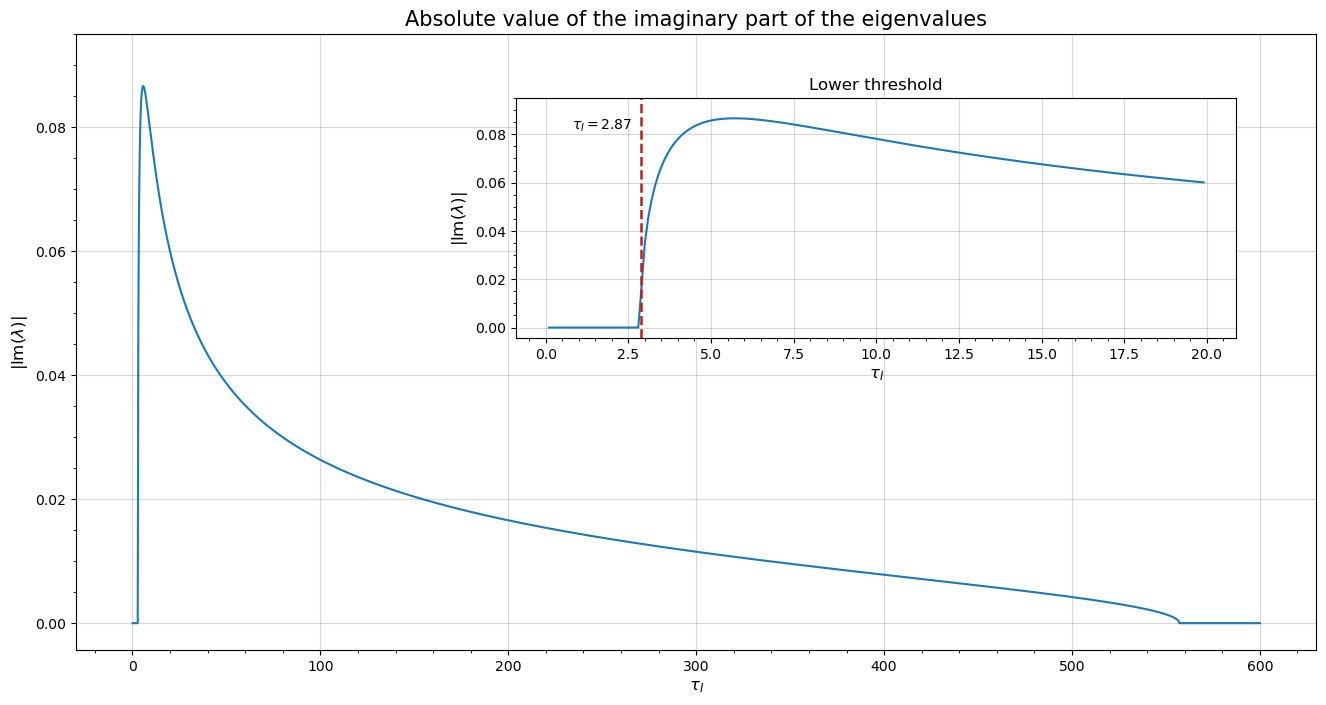

In [3]:
def Jacobian(tau_I):
    return np.array([1/tau_E*np.array([M[0, 0]-1, M[0, 1]]), 1/tau_I*np.array([M[1, 0], M[1, 1]-1])])

tau_I_vec = np.linspace(0, 600, 6001)[1:]
tau_minus = 280-160*np.sqrt(3)

img_eig = [] 

for i in range(len(tau_I_vec)):
    Jac_i = Jacobian(tau_I_vec[i])
    img_eig.append(np.linalg.eigvals(Jac_i)[0].imag)
    
fig, ax = plt.subplots(figsize=(16,8))

ax.plot(tau_I_vec, img_eig)
ax.set_title('Absolute value of the imaginary part of the eigenvalues', fontsize = 15)
ax.set_xlabel('$\\tau_I$', fontsize = 12)
ax.set_ylabel('$|\\operatorname{Im}(\\lambda)|$', fontsize = 12)

ax.grid(alpha=0.5)
ax.minorticks_on()
ax.set_ylim(ymax=0.095)

l, b, w, h = .4, .5, 0.45, .3
ax_in = fig.add_axes([l, b, w, h])

ax_in.plot(tau_I_vec[0:199], img_eig[0:199], color='C0')
ax_in.axvline(tau_minus, color = 'firebrick', linewidth=1.8, linestyle='dashed')
ax_in.annotate(
    '$\\tau_I=2.87$', xy=(tau_minus, 0.085),  xycoords='data',
    xytext=(tau_minus-2.08, 0.082), fontsize=10
)

ax_in.set_title('Lower threshold')
ax_in.set_xlabel('$\\tau_I$', fontsize = 12)
ax_in.set_ylabel('$|\\operatorname{Im}(\\lambda)|$', fontsize = 12)

ax_in.grid(alpha=0.5)
ax_in.minorticks_on()
ax_in.set_ylim(ymax=0.095)

plt.show()

# Complex conjugate eigenvalues
Here we consider the case where $2.87\lesssim\tau_I\lesssim557.13$, the argument of the square root is negative and the eigenvalues are complex conjugate. This implies that the behaviour around the fixed point is oscillatory. The stability is determined by the $\operatorname{Re}(\lambda_{\pm})$:
- If $\operatorname{Re}(\lambda_{\pm})<0\iff \tau_I<40$ the fixed point is stable and the trajectory spirals into it.
- If $\operatorname{Re}(\lambda_{\pm})<0\iff \tau_I>40$ the fixed point is unstable and the system spirals out of it, converging towards a so-called limit cycle.
- If $\operatorname{Re}(\lambda_{\pm})=0\iff \tau_I=40$ the fixed point is a center and the solution is a closed orbit which is neutrally stable.


In [4]:
vE_0 = 20
vI_0 = 20
time_vec = np.linspace(0, 1000, 1001)

def plot_complex_conj(tau_I):
    # fig, ax = plt.subplots(1, 3, figsize=(16, 8))
    
    plt.figure(figsize=(16, 8))
    ax = [plt.subplot(211), plt.subplot(223), plt.subplot(224)]
    
    # simulation
    y_sim = odeint(Sys, y0=[vE_0, vI_0], t=time_vec, args=(tau_I, ))
    
    ax[0].plot(time_vec, y_sim[:, 0], linewidth=2, label='$v_E(t)$', color='forestgreen')
    ax[0].plot(time_vec, y_sim[:, 1], linewidth=2, label='$v_I(t)$', color='C1')
    ax[0].set_xlabel('Time [s]', fontsize=12)
    ax[0].set_ylabel('$\\overrightarrow{v}$', fontsize=12)
    ax[0].legend(edgecolor='black', facecolor='linen', fontsize=12, loc ='upper left')
    ax[0].grid(alpha=0.5)
    ax[0].set_title('Simulation with $\\tau_I=%i$' %tau_I, fontsize=15)
    
    # streamplot
    x = np.linspace(10, 40, 20)
    y = np.linspace(10, 40, 20)

    X1 , Y1  = np.meshgrid(x, y)                    # create a grid
    DX1, DY1 = Sys([X1, Y1], 0, tau_I)                 # compute growth rate on the grid
    
    ax[1].streamplot(X1, Y1, DX1, DY1, linewidth=1)
    ax[1].plot(fp[0], fp[1], "ro", markersize = 10, markeredgecolor="black", markerfacecolor="C3", label='Fixed point')
    ax[1].set_xlim(10, 40)
    ax[1].set_ylim(10, 40)
    ax[1].set_xlabel('$v_E$', fontsize = 12)
    ax[1].set_ylabel('$v_I$', fontsize = 12)
    ax[1].grid(alpha=0.5)
    ax[1].set_title('Phase portrait with $\\tau_I=%i$' %tau_I, fontsize=15)
    
    # trajectory
    ax[2].scatter(y_sim[:, 0],  y_sim[:, 1], s=5, color='C0')
    ax[2].plot(fp[0], fp[1], "ro", markersize = 10, markeredgecolor="black", markerfacecolor="C3", label='Fixed point')
    ax[2].set_xlabel('$v_E$', fontsize = 12)
    ax[2].set_ylabel('$v_I$', fontsize = 12)
    ax[2].grid(alpha=0.5)
    ax[2].set_title('System trajectory with $\\tau_I=%i$' %tau_I, fontsize=15)
    
    # show
    plt.tight_layout()
    plt.show()


## Simulation in the stable regime

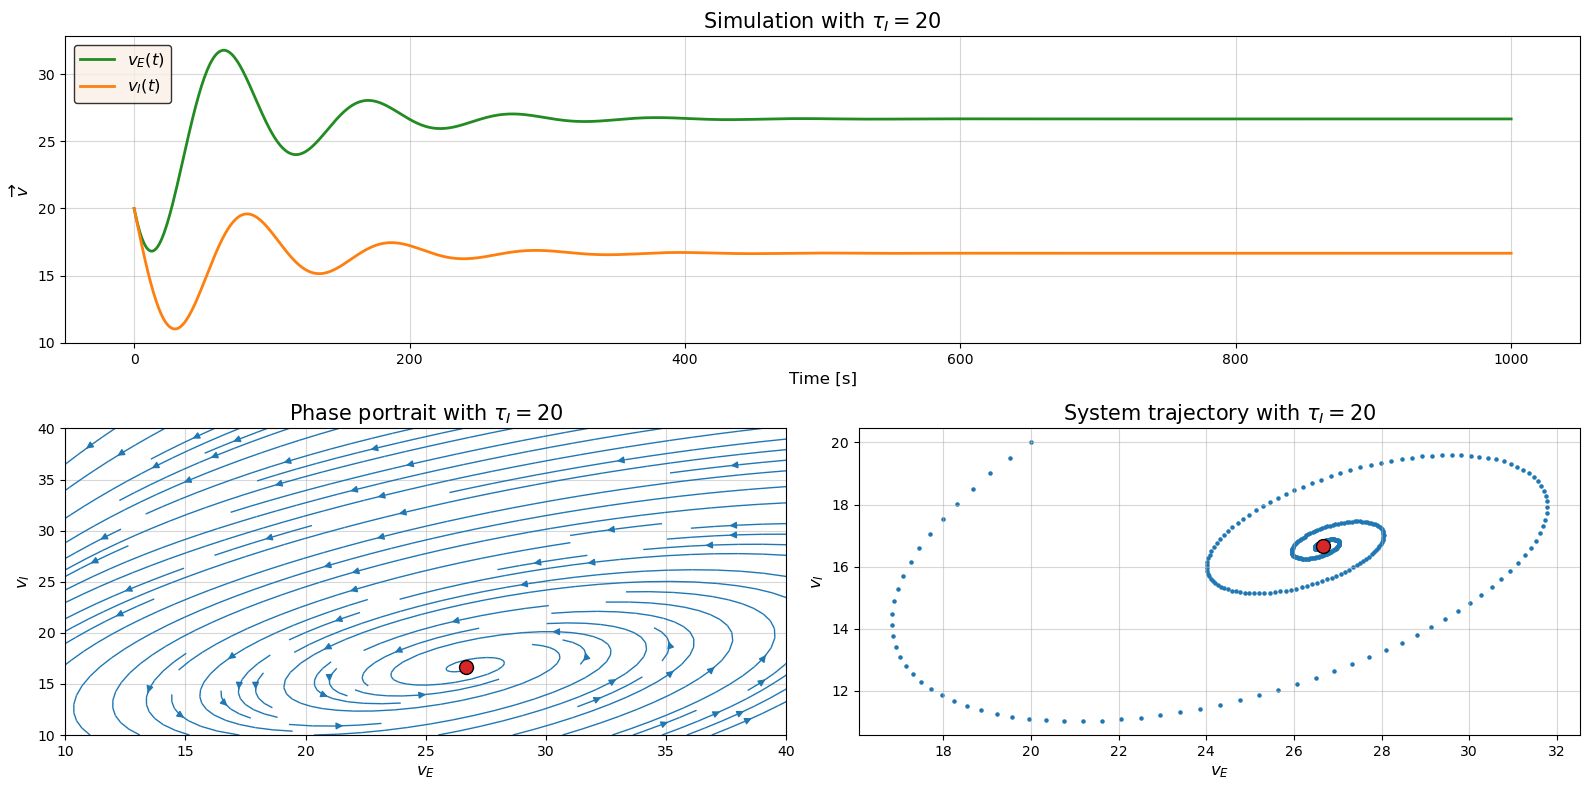

In [5]:
plot_complex_conj(20)

## Simulation in the limit cycle regime

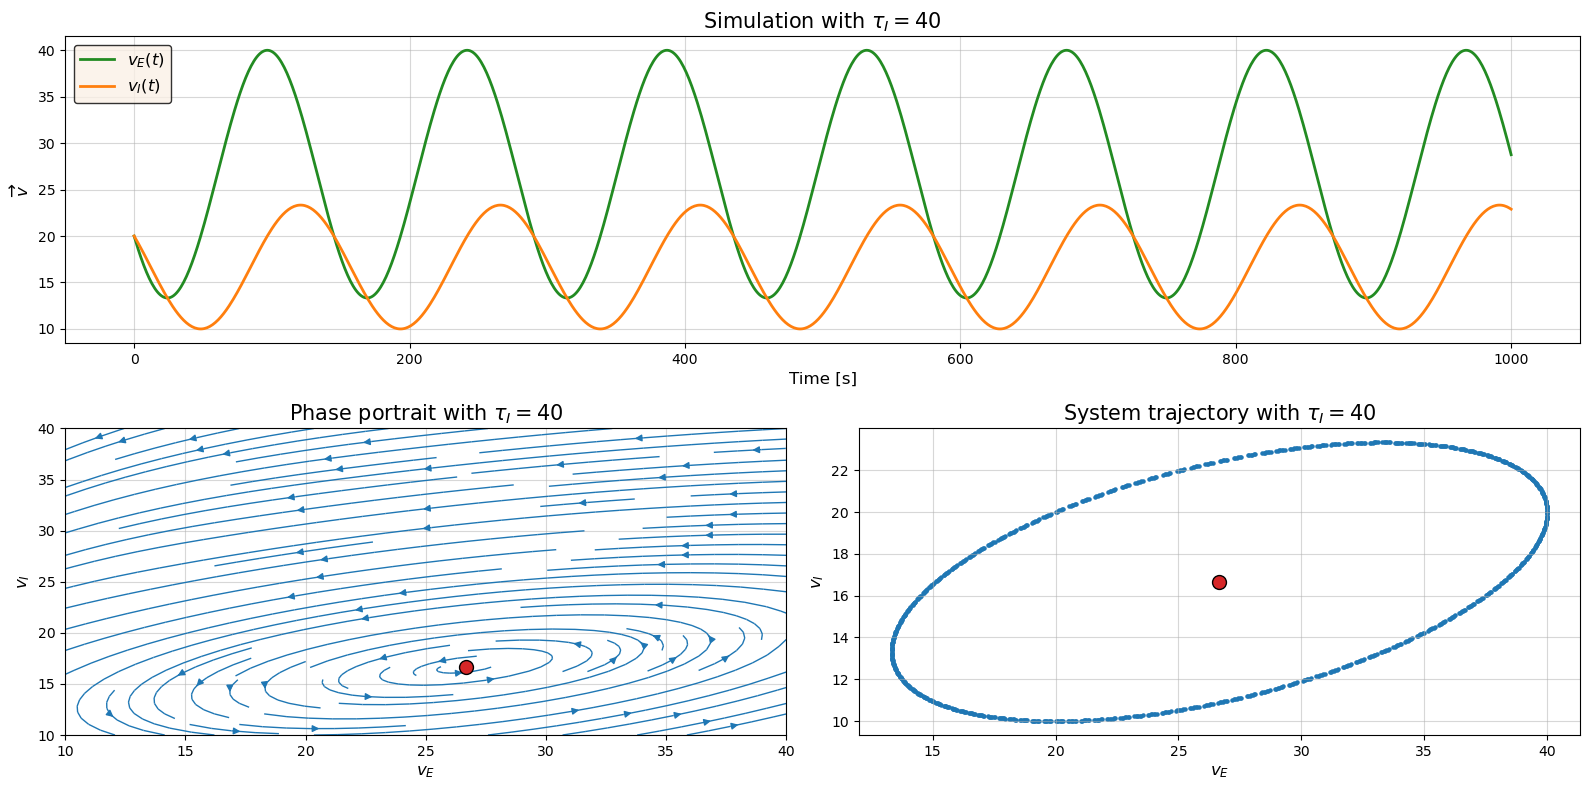

In [6]:
plot_complex_conj(40)

## Simulation in the critical case

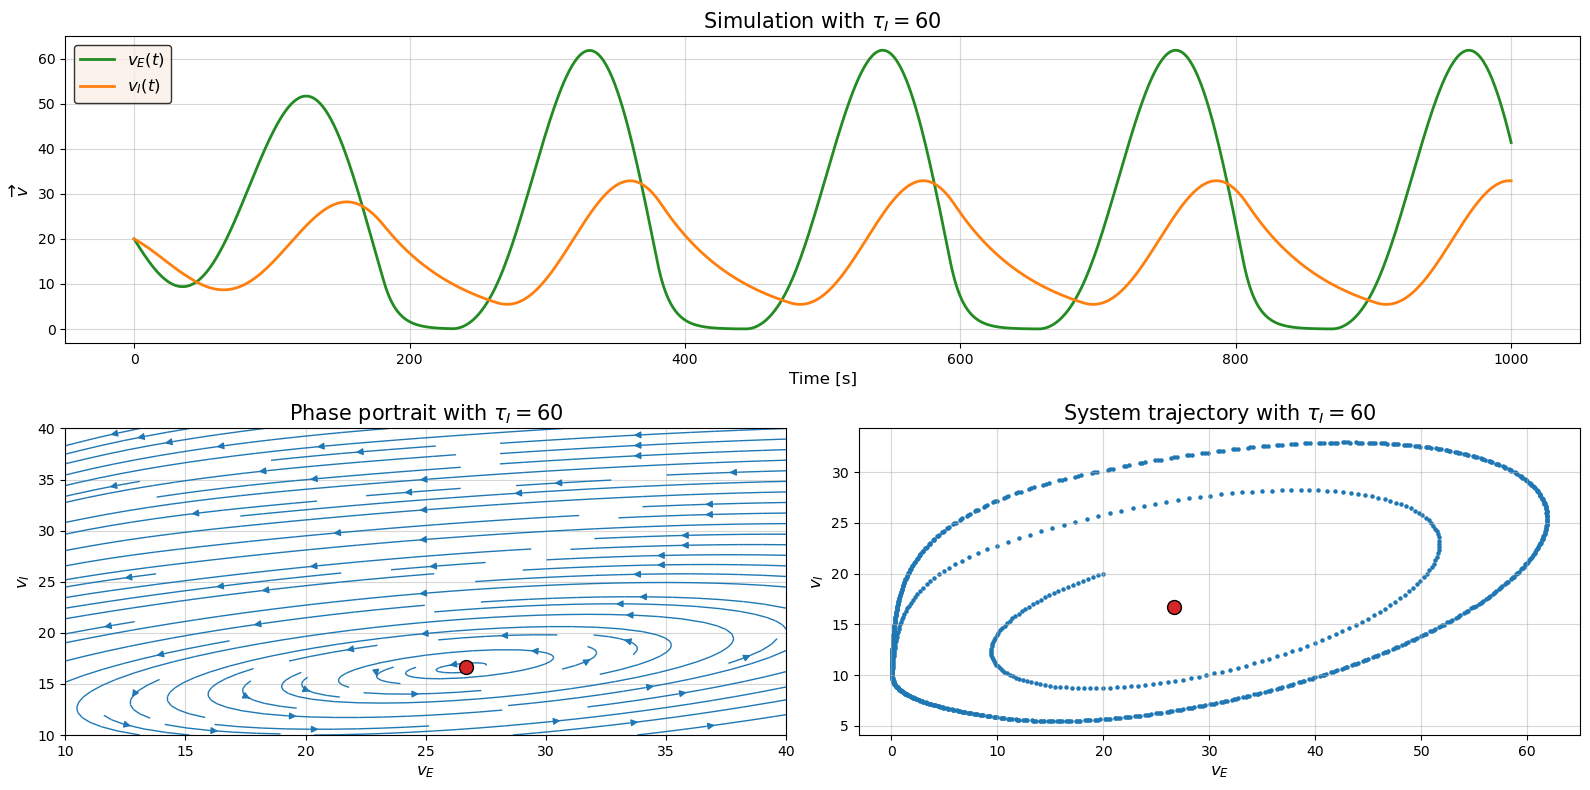

In [7]:
plot_complex_conj(60)

# Real-valued eigenvalues
If $0<\tau_I\lesssim 2.87$ or $\tau_I\gtrsim 557.13$ the eigenvalues of the Jacobian are real. The stability of the fixed point is determined by the sign of the largest eigenvalue, so $\lambda_+$. Considering only the physical values of $\tau_I$ and restricting it to the interval where the eigenvalues are real, finally we get that:
$$
\begin{align}
    &\lambda_{+}\in\mathbb{R} \text{ and } \lambda_{+}<0 \iff 0<\tau_I\lesssim 2.87 \\
    &\lambda_{+}\in\mathbb{R} \text{ and } \lambda_{+}>0 \iff \tau_I\gtrsim 557.13 
\end{align}
$$
In the first case the 2 eigenvalues are both negative and the fixed point is stable. In the second case, instead, at least one of them is positive and the fixed point is unstable.

Let's see this doing some simulations. 

## Simulation in the case of real eigenvalues and stable fixed point

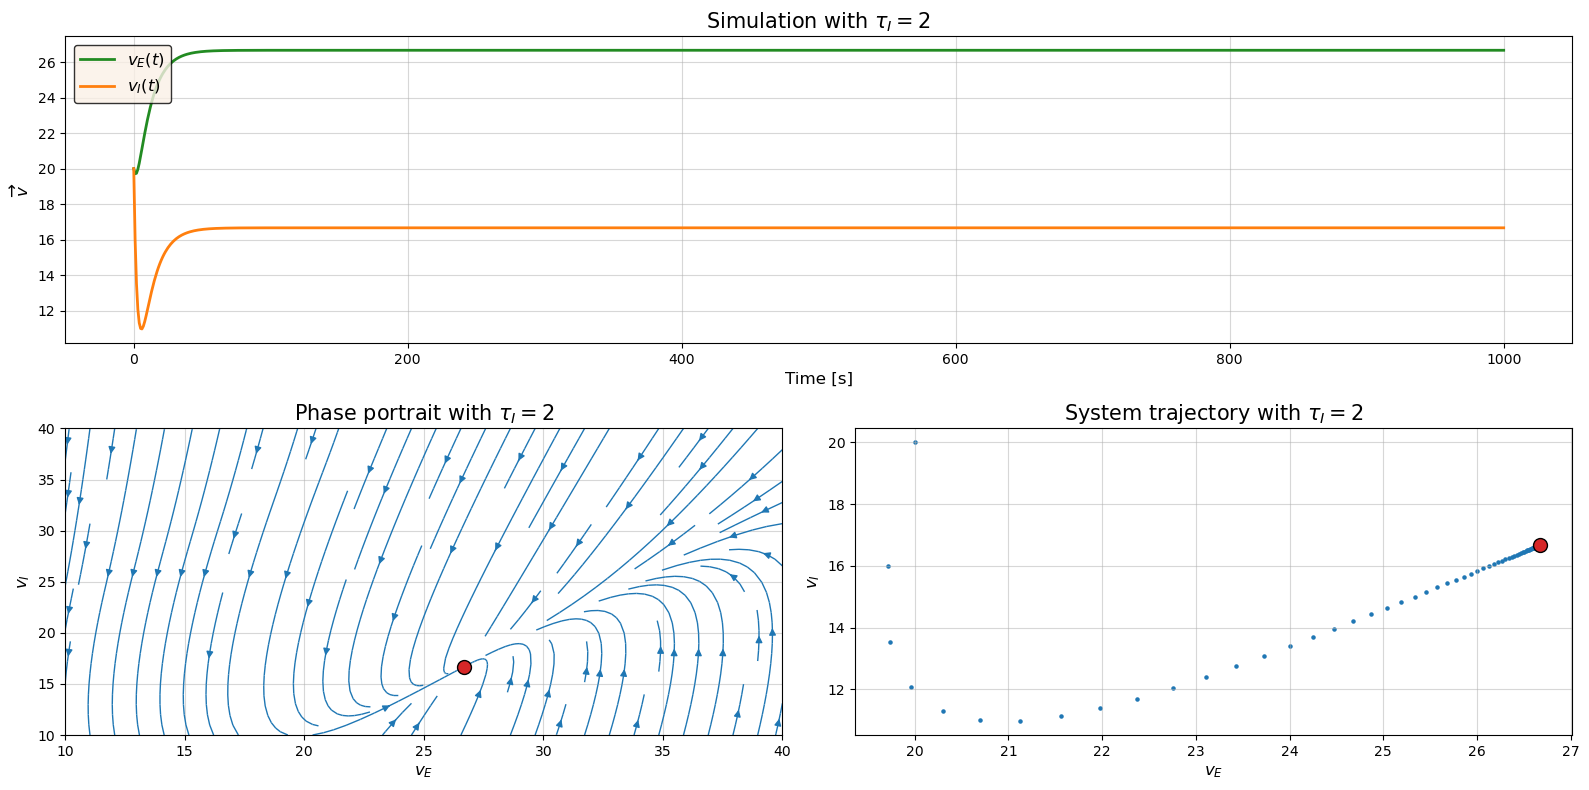

In [8]:
plot_complex_conj(2)

## Simulation in the case of real eigenvalues and unstable fixed point

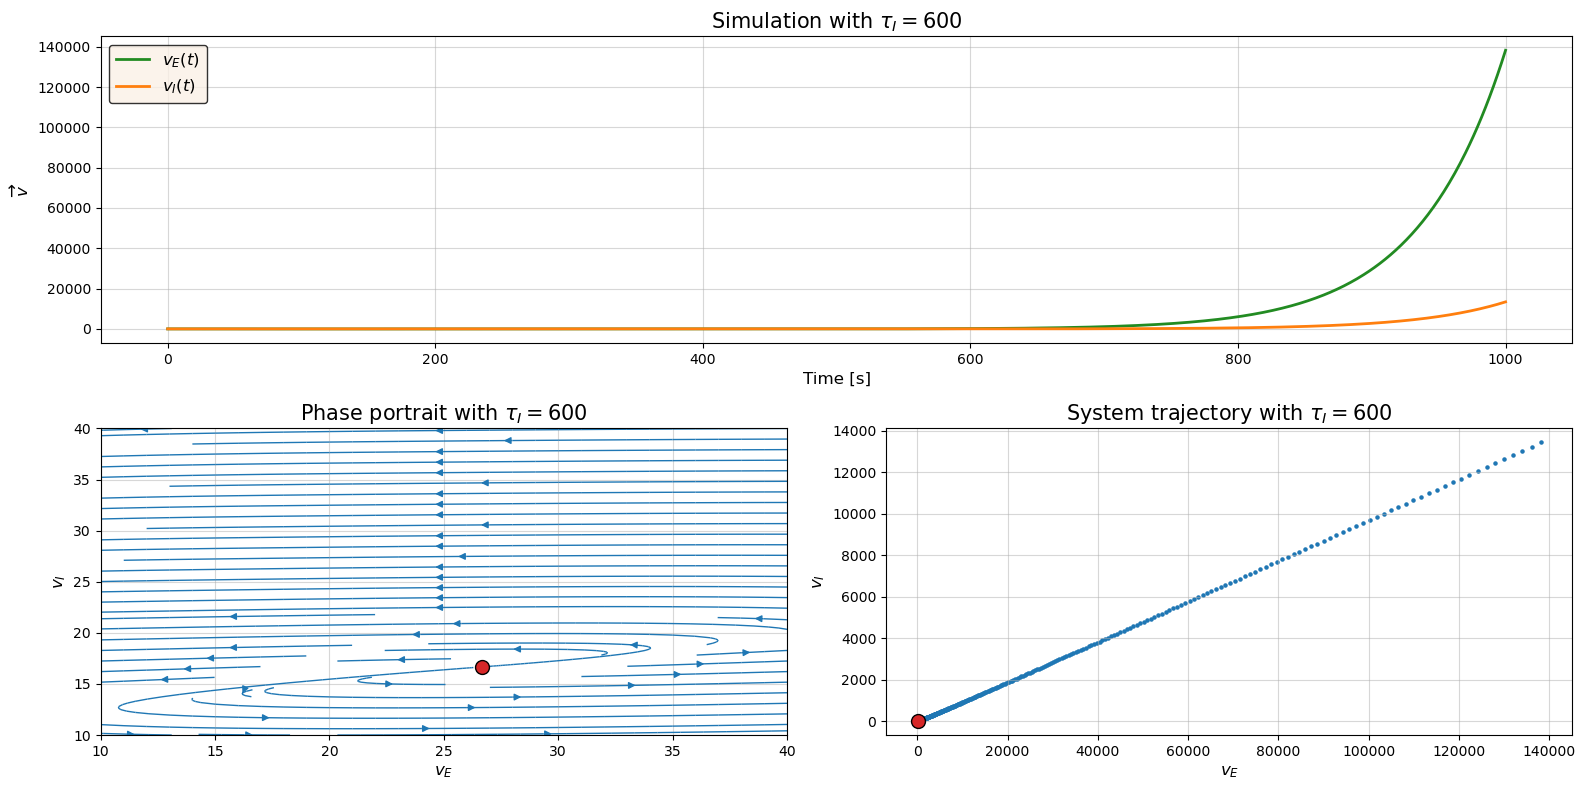

In [9]:
plot_complex_conj(600)